In [99]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import einops as E

In [73]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

In [3]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [84]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 16

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [85]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [86]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

In [87]:
from collections import defaultdict
def predict(model,d_test,support_images,support_labels,n_predictions=10):

    results = defaultdict(list)

    # compute inference and save predictions and metrics for n_predictions

    for i in tqdm(range(n_predictions)):
        image, label = d_test[i]
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    # visualize the results, along with their scores
    scores = results.pop('score')
    results.pop('Soft Prediction')
    visualize_tensors(results,
                    col_names=[f'Dice = {100*s:.1f}' for s in scores],
                    title='Test Predictions',
                    col_wrap=n_predictions)

100%|██████████| 10/10 [00:00<00:00, 33.53it/s]


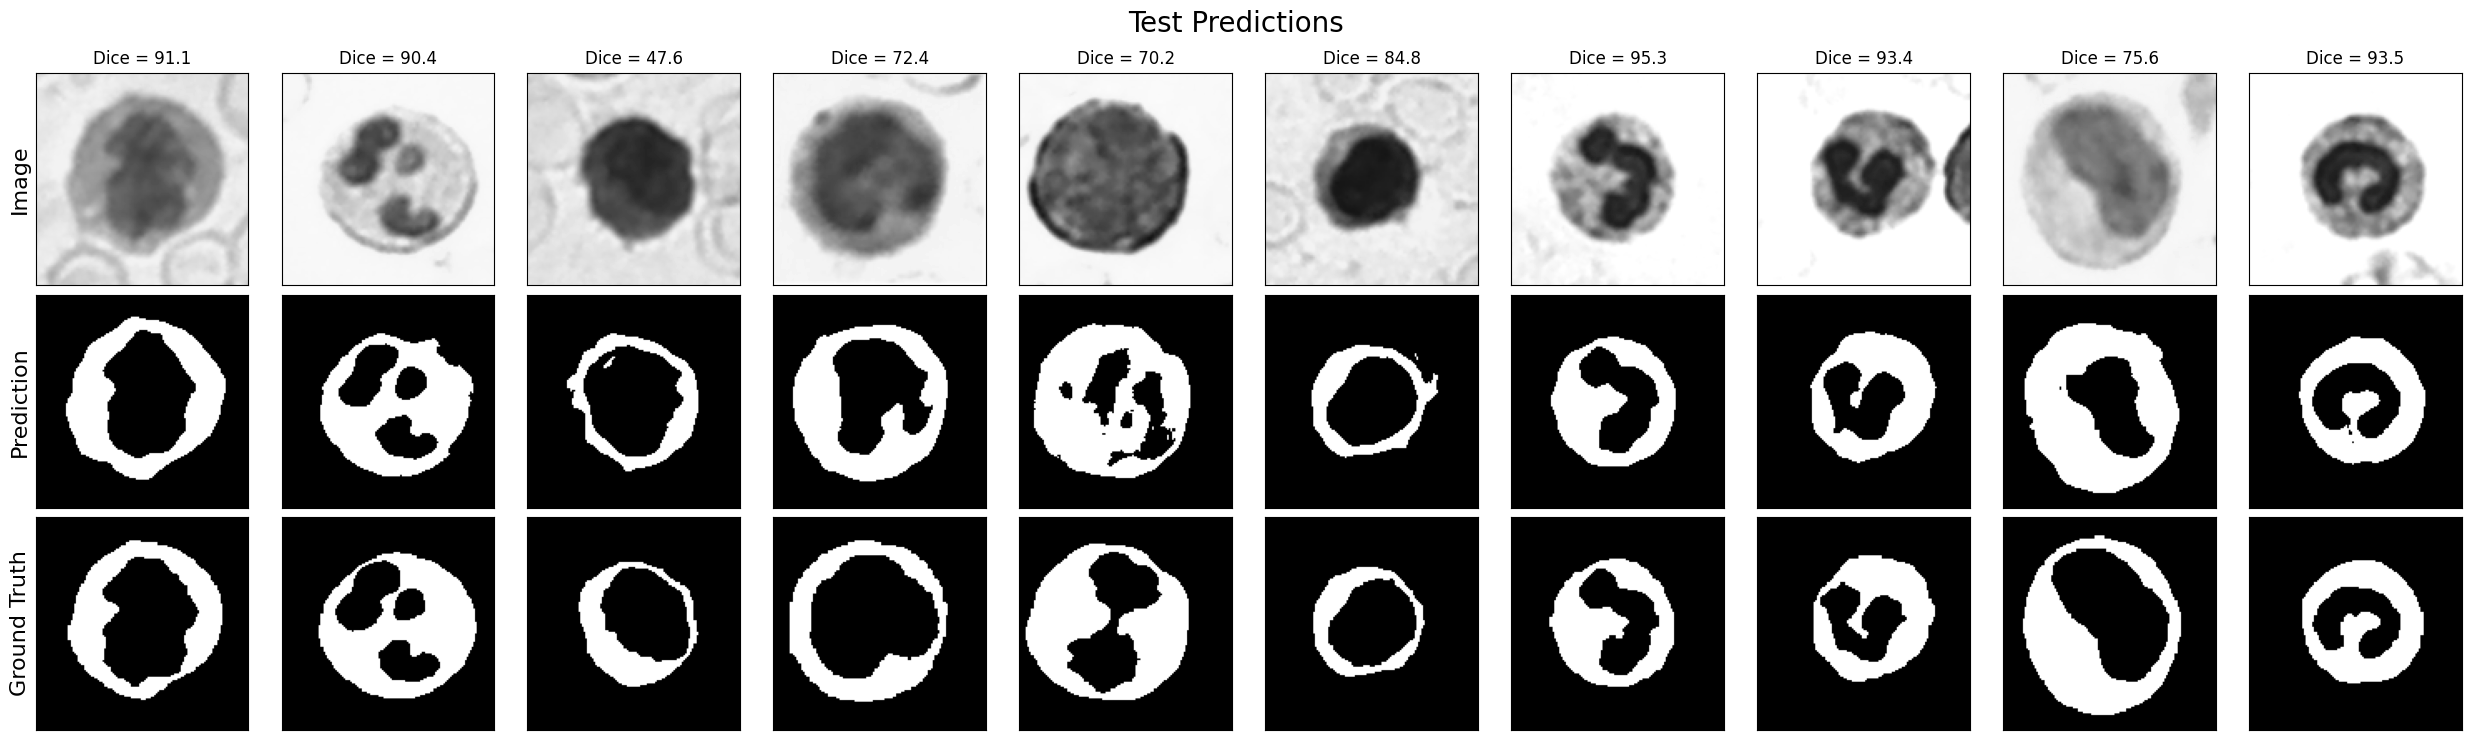

In [88]:
predict(model,d_test,support_images,support_labels,n_predictions=10)

In [89]:
# helpful function to sample support data
def sample_support(seed,support_size,d_support):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

In [90]:

# setup the number of predictions and ensembling
def inference_vary_se(support_size=1, n_ensemble=1,n_predictions=1,seed=1,d_support=d_support,d_test=d_test):    
    # # get various support sets
    # seeds = range(n_ensemble)
    # supports = {
    #     seed: sample_support(seed)
    #     for seed in range(n_ensemble)
    # }
    scores = []
    # go through the number of experiments
    for i in (range(n_predictions)):

        # go through the number of predictions we will ensemble
        results = defaultdict(list)
        for j in range(n_ensemble):
            # get support set and query
            support_images, support_labels = sample_support(j+seed,support_size,d_support=d_support)
            image, label = d_test[i]

            # perform inference
            vals = inference(model, image, label, support_images, support_labels)
            for k, v in vals.items():
                results[k].append(v)

        results['Image'].append(image)
        ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
        results['Soft Prediction'].append(ensemble)
        results['Prediction'].append(ensemble.round())
        results['Ground Truth'].append(label)
        results['score'].append(dice_score(ensemble.round().clip(0,1), label.to(device)))

        scores.append(results['score'][-1])
    return scores

In [95]:
scores = inference_vary_se(support_size=64,n_ensemble=1,n_predictions=len(d_test))

In [96]:
scores = np.array(scores)
print(f'Average Dice Score: {100*scores.mean():.1f} +/- {100*scores.std():.1f}')

Average Dice Score: 89.0 +/- 8.4


In [97]:
d_support = WBCDataset('JTSC', split='support', label='nucleus')
d_test = WBCDataset('JTSC', split='test', label='nucleus')
scores = inference_vary_se(support_size=64,n_ensemble=1,n_predictions=len(d_test),d_support=d_support,d_test=d_test)
scores = np.array(scores)
print(f'Average Dice Score: {100*scores.mean():.1f} +/- {100*scores.std():.1f}')


Average Dice Score: 93.6 +/- 5.8


100%|██████████| 10/10 [00:00<00:00, 28.97it/s]


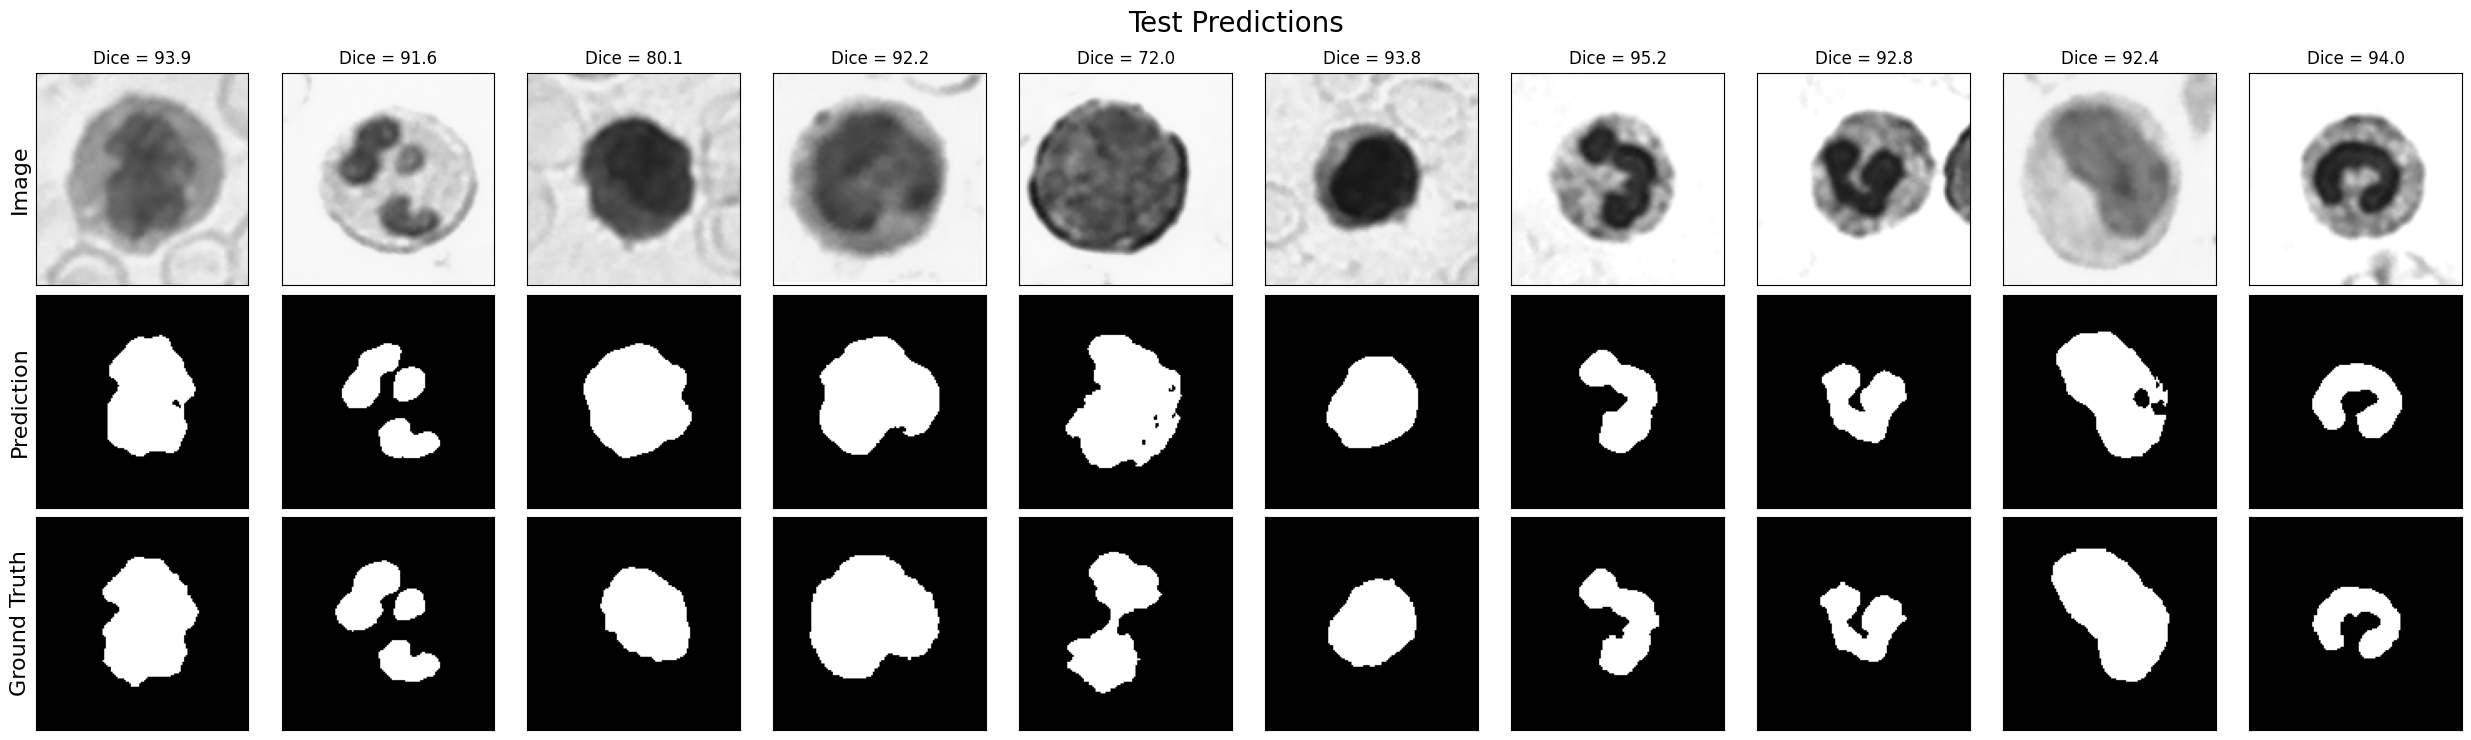

In [98]:
support_images, support_labels = sample_support(1,16,d_support)
predict(model,d_test,support_images,support_labels,n_predictions=10)

100%|██████████| 10/10 [00:00<00:00, 51.60it/s]


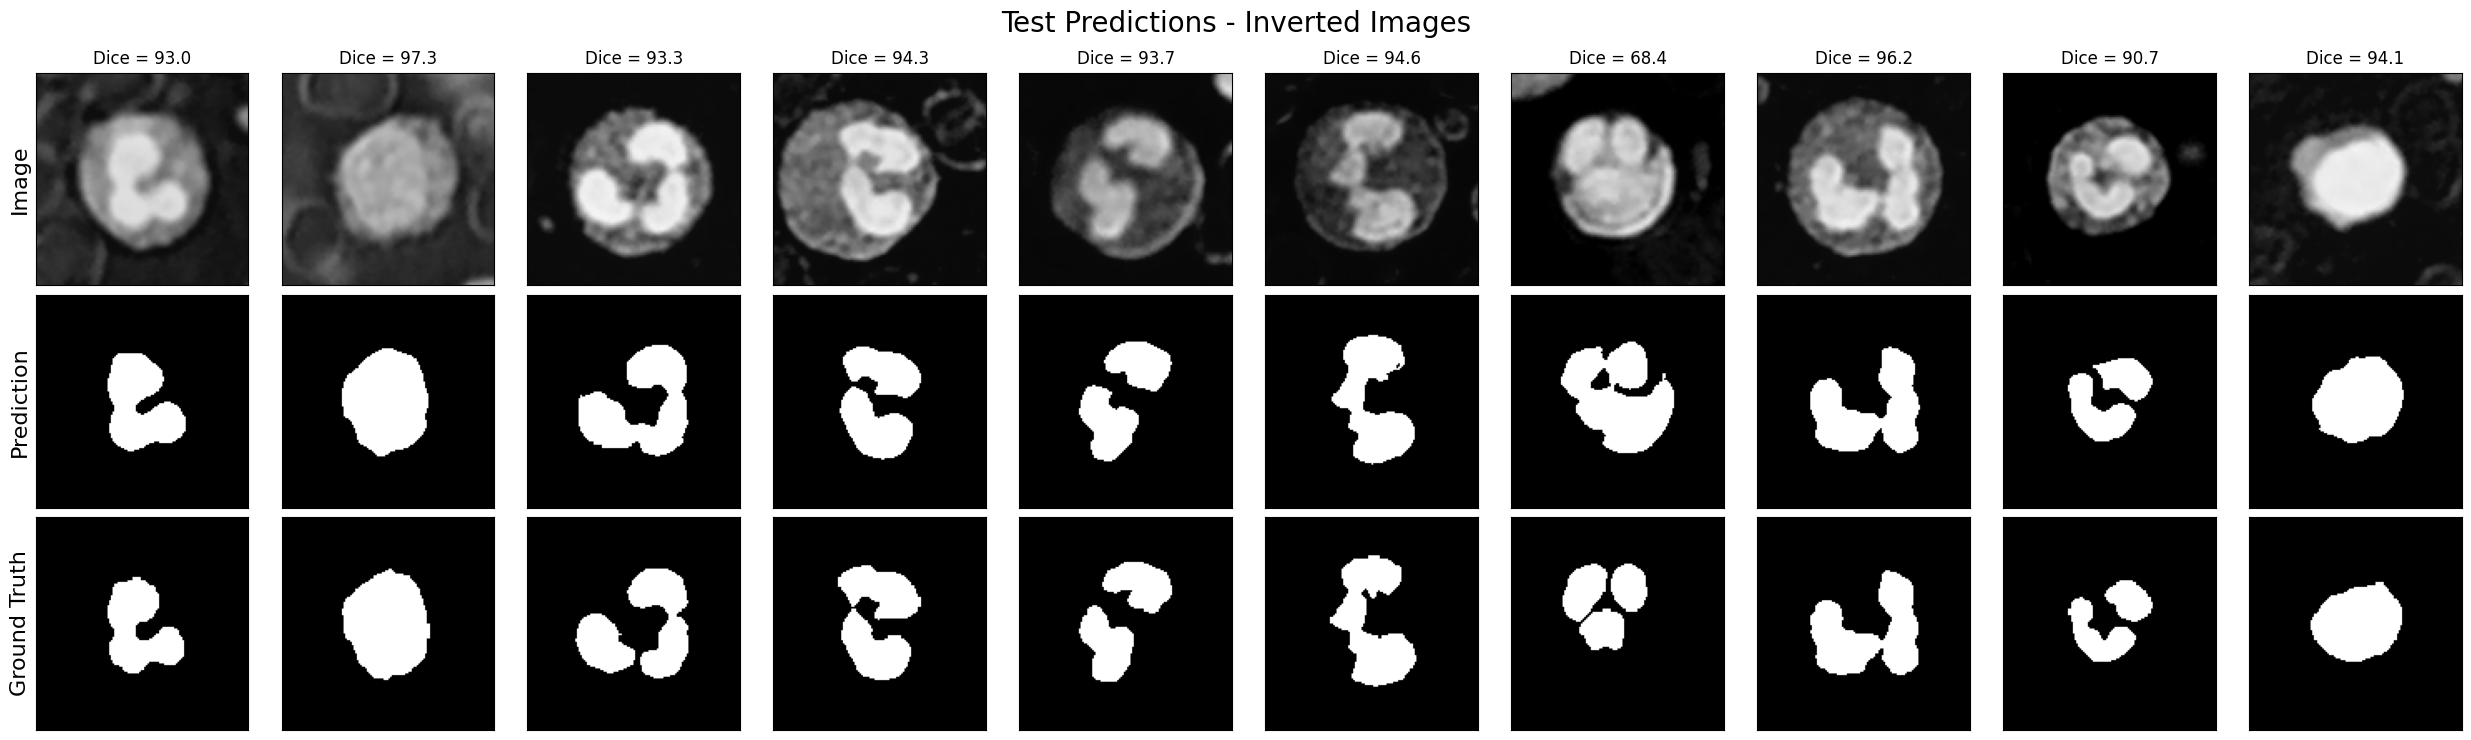

In [41]:
d_support = WBCDataset('JTSC', split='support', label='nucleus')
d_test = WBCDataset('JTSC', split='test', label='nucleus')

# run inference on inverted images (both the query image of interest, and support data)
n_predictions = 10
support_images, support_labels = sample_support(1,16,d_support)
support_images = 1 - support_images
results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, 1-image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
results.pop('Soft Prediction')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Inverted Images', col_wrap=n_predictions)

In [42]:
d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [71]:
n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    results.pop('Soft Prediction')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 5, 128, 128] to have 3 channels, but got 5 channels instead

### Multi label

In [79]:
d_support = WBCDataset('JTSC', split='support', label=None)
d_test = WBCDataset('JTSC', split='test', label=None)

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [80]:
# prepare a function that will perform inference on all available labels
import torch.nn.functional as F

@torch.no_grad()
def inference_multi(model, image, label_onehot, support_images, support_labels_onehot):
    # get data
    n_labels = label_onehot.shape[0]
    image, label_onehot = image.to(device), label_onehot.to(device)

    # go through label
    all_logits = []
    soft_pred_onehot = []
    for k in range(n_labels):
        # extract the right label
        label = label_onehot[k:k+1]
        support_labels = support_labels_onehot[:,k:k+1]

        # run inference on this label
        logits = model(
            image[None],
            support_images[None],
            support_labels[None]
        )[0] # outputs are logits
        soft_pred = torch.sigmoid(logits)
        soft_pred_onehot.append(soft_pred)

    # get multi-label score
    soft_pred_onehot = torch.stack(soft_pred_onehot)
    hard_pred = F.softmax(10*soft_pred_onehot,dim=0)
    scores = []
    for k in range(n_labels):
        # plt.imshow(hard_pred[k].detach().cpu().numpy().squeeze())
        # plt.show()
        # plt.imshow(label_onehot[k].detach().cpu().numpy().squeeze())
        # plt.show()
        # break
        score = dice_score(hard_pred[k], label_onehot[k].squeeze())
        scores.append(score)
    # return the predictions and labels
    return {'Image': image,
            'Soft Prediction': soft_pred_onehot,
            'Prediction': hard_pred,
            'Ground Truth': label_onehot,
            'score': np.mean(scores)}

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


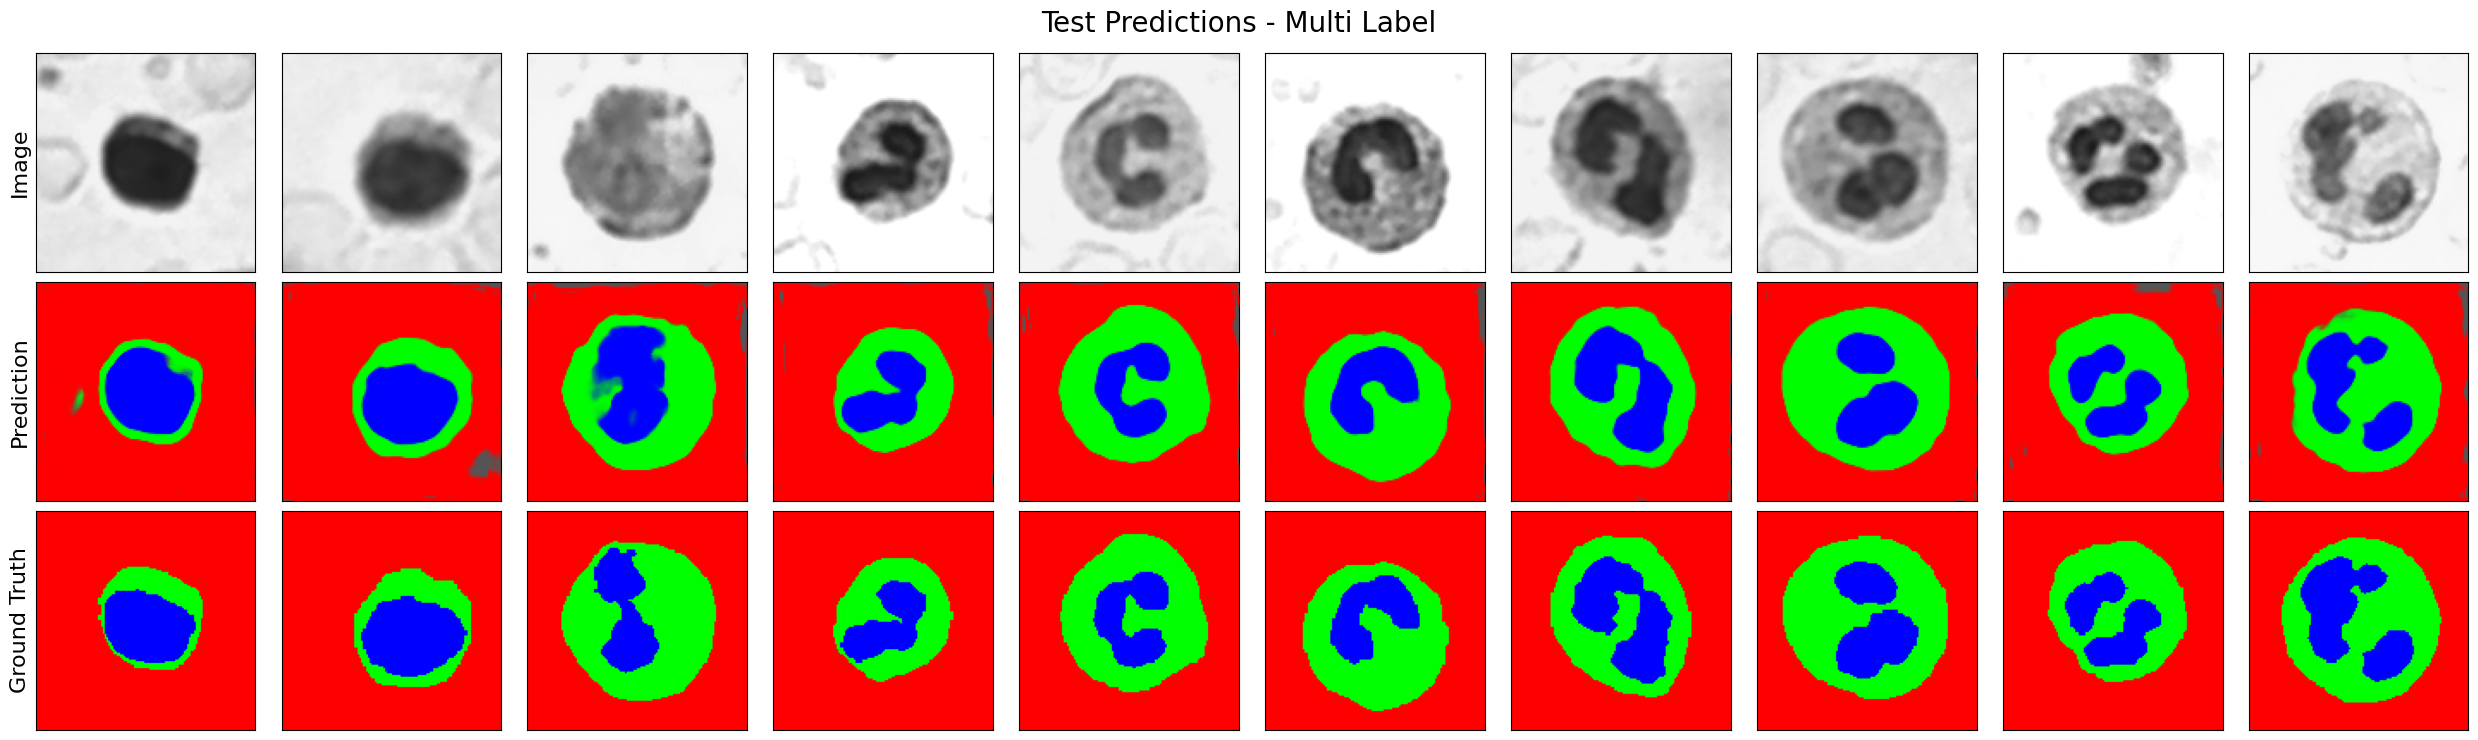

In [83]:
n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference_multi(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
results.pop('Soft Prediction')
visualize_tensors(results, title='Test Predictions - Multi Label', col_wrap=n_predictions)

210
